In [3]:
import sys
from __future__ import division

In [4]:
import numpy as np
from phasor.utilities.ipynb.displays import *
from phasor.utilities.ipynb.sympy import *

import declarative

from declarative.bunch import (
    DeepBunch
)

import phasor.math.dispatched as dmath 
#import phasor.math.dispatch_sympy

Populating the interactive namespace from numpy and matplotlib
Sympy version:  1.0


In [5]:
import phasor.utilities.version as version
print(version.foundations_version())

from phasor.utilities.np import logspaced

from phasor import optics
from phasor import base 
from phasor import signals 
from phasor import system
from phasor import readouts 

import scipy.signal

b'2017-09-29 14:18:38 -0400 (bbb2b427cdfd3d3fc1a626fa4fa5404882cc9820)'


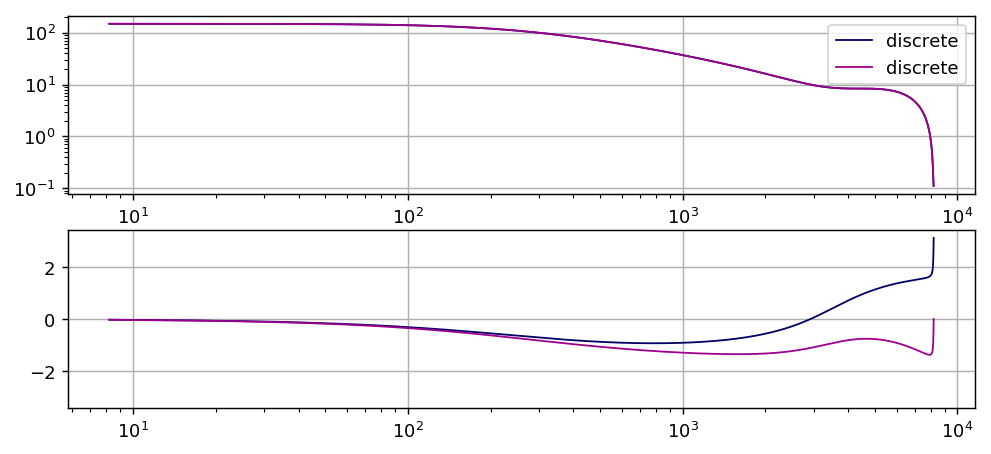

In [1021]:
F_AC1 = np.linspace(0, 16384/2, 1000)
#F_AC2 = logspaced(1, 16384 * .8, 100)
F_AC = np.concatenate([F_AC1, F_AC2])
F_AC = F_AC1
F_AC = np.concatenate([F_AC, -F_AC])
F_AC.sort()
#F_AC = np.linspace(0, 16384 * .8, 1000)
    
ZPKz = (
    [
        .2 + .5j,
        .2 - .5j,
        -.99,
    ], 
    [
        .9,
        -.2,
    ], 
    10
)

F_nyquist = 16384 / 2

b,a = scipy.signal.zpk2tf(*ZPKz)


Fb = mplfigB(Nrows=2)
w, h = scipy.signal.freqz_zpk(*ZPKz , worN = F_AC / F_nyquist * np.pi)
F_exact = h
Fb.ax0.loglog(F_AC, abs(h), label = 'discrete')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'discrete')

w, h = scipy.signal.freqz(b, a , worN = F_AC / F_nyquist * np.pi)
Fb.ax0.loglog(F_AC, abs(h), label = 'discrete')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'discrete')

Fb.ax0.legend()

In [1003]:
order_b = len(b)
order_a = len(a)
Z = np.exp(-1j * np.pi * F_AC / F_nyquist)
Z_a = np.vstack([Z**j for j in range(order_a)]).T
Z_b = np.vstack([Z**j for j in range(order_b)]).T

In [1004]:
Z_a.shape
a_fit = None
b_fit = None
a_fit = a
b_fit = b

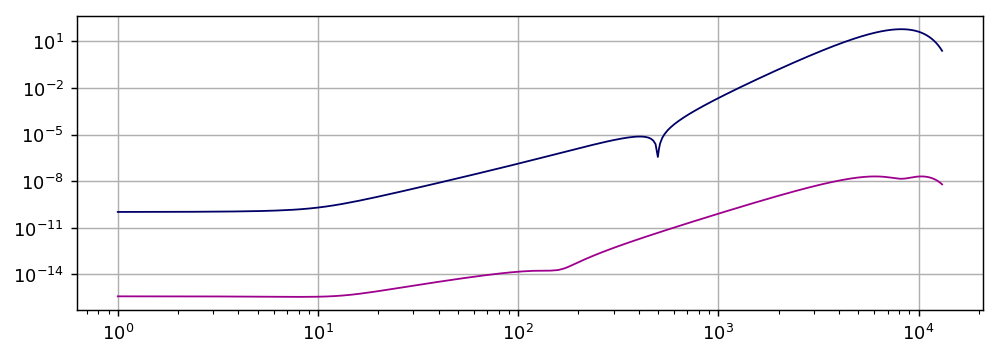

In [1010]:
if a_fit is None:
    M_b = np.einsum('ij,i->ij', Z_b, 1/F_exact * abs(F_exact)**.5)
    M_a = Z_a * abs(F_exact).reshape(-1,1)**.5
    M_b2 = Z_b / abs(F_exact).reshape(-1,1)**.5
    M_a2 = np.einsum('ij,i->ij', Z_a, F_exact / abs(F_exact)**.5)
else:
    a_z = np.einsum('ij,j->i', Z_a, a_fit)
    b_z = np.einsum('ij,j->i', Z_b, b_fit)
    M_b = np.einsum('ij,i->ij', Z_b, 1/F_exact / np.abs(a_z))
    M_a = Z_a / np.abs(a_z).reshape(-1,1)
    M_b2 = Z_b / np.abs(b_z).reshape(-1,1)
    M_a2 = np.einsum('ij,i->ij', Z_a, F_exact / np.abs(b_z))
    Fb = mplfigB(Nrows=1)
    w, h = scipy.signal.freqz(b, a, worN = F_AC / F_nyquist * np.pi)
    Fb.ax0.loglog(F_AC, abs(a_z), label = 'discrete')
    Fb.ax0.loglog(F_AC, abs(b_z), label = 'discrete')

X = np.block([[M_b, -M_a], ])
red1 = np.einsum('ji,jk->ki', X.conjugate(), X)
X = np.block([[M_b2, -M_a2]])
red2 = np.einsum('ji,jk->ki', X.conjugate(), X)
X = np.block([[M_b, -M_a], [M_b2, -M_a2]])
red3 = np.einsum('ji,jk->ki', X.conjugate(), X)

X = np.block([[M_b, -M_a], ])
#X = np.block([[M_b2, -M_a2], ])
X.shape

In [1011]:
use_svd = True
if not use_svd:
    S,V = scipy.linalg.eigh(red3)
    b_fit = V[0:order_b, 0]
    a_fit = V[order_b:order_b + order_a, 0]
    print(S)
else:
    U,S,V = np.linalg.svd(X)
    b_fit = V[-1, 0:order_b]
    a_fit = V[-1, order_b:order_b + order_a]
    print(S)
    

[  2.90725058e+17   5.76756538e+14   9.05106409e+11   9.17900514e+10
   2.60650537e+10   1.64683683e+09   5.79972213e+08   5.08349768e+08
   1.63140459e+06   7.11954031e+04   4.44645744e+03   3.15703681e+01
   1.12912463e+00]


In [1012]:
Xcut = X[:, order_b]

Xsub = np.hstack([X[:, :order_b],  X[:, order_b+1:]])
sol, res, rank, s = scipy.linalg.lstsq(Xsub, Xcut, lapack_driver = 'gelsd')
b_fit = sol[:order_b]
a_fit = np.concatenate([[-1], sol[order_b:]])
print(s)

[  2.90725058e+17   5.76756537e+14   9.05021099e+11   8.49716141e+10
   2.60649806e+10   1.64673276e+09   5.79972148e+08   4.01925835e+08
   1.08967546e+06   3.92501415e+04   1.90338999e+03   9.20894553e+00]


In [1013]:
b_fit

array([  9.41398970e-10 -4.99708292e-15j,
        -6.73796686e-09 +1.67922184e-14j,
         1.63359581e-08 -2.03987578e-14j,
        -1.82809220e-08 +1.04249319e-14j,
         9.79866735e-09 -1.83614983e-15j,  -2.05713580e-09 +1.48396217e-17j])

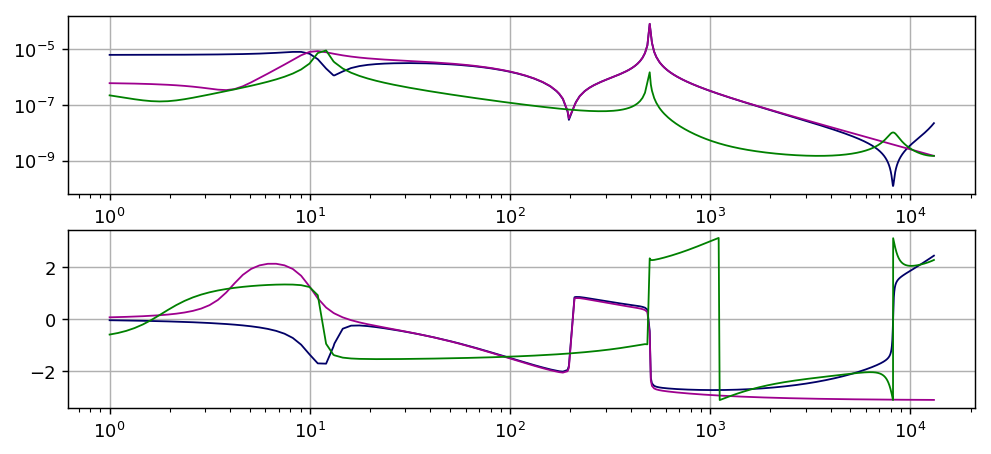

In [1014]:
Fb = mplfigB(Nrows=2)
w, h = scipy.signal.freqz(b, a, worN = F_AC / F_nyquist * np.pi)
Fb.ax0.loglog(F_AC, abs(h), label = 'discrete')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'discrete')
w, h = scipy.signal.freqs_zpk(*ZPKs , worN = F_AC  * np.pi * 2)

F_exact = h
Fb.ax0.loglog(F_AC, abs(h), label = 'cont')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'cont')

w, h = scipy.signal.freqz(b_fit, a_fit, worN = F_AC / F_nyquist * np.pi)
Fb.ax0.loglog(F_AC, abs(h), label = 'fit', color = 'green')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'fit', color = 'green')

In [953]:
Z,T = scipy.linalg.schur(red3)
Z
@np.vectorize
def fmt(v):
    return "{0:.2e}".format(v)
    
def matrix_markdown(mat, fmt = fmt):
    display(Markdown(
        tabulate.tabulate(
            fmt(mat),
            tablefmt='pipe',
            headers = [''] * red1.shape[0]
    )))
    return
red3.shape

In [714]:
a

array([  1.        ,  -5.95716765,  14.82272486, -19.71904857,
        14.79247603,  -5.93286753,   0.99388286])

In [702]:
a_fit

array([ -1.00000000 +0.00000000e+00j,   5.79248351 -1.41728436e-06j,
       -13.72722481 +7.12666564e-06j,  16.16707426 -1.31654990e-05j,
        -7.38164870 +8.23298009e-06j,  -4.67790066 +5.98485108e-06j,
         9.25685707 -1.30321029e-05j,  -6.31063518 +8.36384647e-06j,
         2.21880515 -2.29107967e-06j,  -0.33781064 +1.97622720e-07j])

In [703]:
b


array([  1.85499696e-08,  -5.55407915e-08,   3.70474780e-08,
         3.68208752e-08,  -5.53707080e-08,   1.84931732e-08])

In [704]:
b_fit

array([ -1.00608575e-09 -9.55680435e-15j,
         1.27808426e-09 +4.20518676e-14j,
         2.15761718e-09 -6.88007416e-14j,
        -4.14126259e-09 +4.96845542e-14j,   1.71163785e-09 -1.33788821e-14j])